## Predicting likelihood of customer cancelling booking

## Cleaning

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import holidays
import xgboost as xgb
import datetime
import random

from prophet import Prophet
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, Binarizer
from sklearn.metrics import RocCurveDisplay, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Input, BatchNormalization
from tensorflow.keras import initializers

In [3]:
pd.options.display.max_columns = None

df = pd.read_csv("C://Users/jgidn/Documents/Programming/Data/hotel_bookings.csv")
df.head().T

,0,1,2,3,4
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel
is_canceled,0,0,0,0,0
lead_time,342,737,7,13,14
arrival_date_year,2015,2015,2015,2015,2015
arrival_date_month,July,July,July,July,July
arrival_date_week_number,27,27,27,27,27
arrival_date_day_of_month,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2


In [4]:
df.shape

(119390, 32)

In [5]:
df.info()
# missing values are from: children, country, agent, company
# company and agent have missing values since most people dont book through a company or travel agency
# children has only 4 missing values so doesnt really make a difference
# country (of the guest) has < 500 missing values again, no way of getting this information and wont really affect anything

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [6]:
print(df.duplicated().sum())

# 32k out of 120k bookings are duplicates
# since this makes up a quarter of the data lets check if there is a reason why this is the case
# lets see if there is any link between number of duplicates for a booking
# and any features of the data

# after a look at randomly sampled duplicates, considering whether the amount of duplicates was linked to something like
# num people booked in, total special requests, num previous cancellations, num previous bookings etc
# but there does not appear to be a pattern that i can see from this data

# duplicates could be related to when a booking is updated on the system in some way
# lets assume these are just duplicates of the same booking and remove them for now

df = df.drop_duplicates()

31994


In [7]:
# if a travel agency or a company didnt book the hotel then it must have been personally booked
# if someone didnt use an agent or company then lets give the personal booking an ID of 0 since this ID is not already taken in either column
df["company"] = df["company"].fillna(0)
df["agent"] = df["agent"].fillna(0)

In [8]:
# we will fill missing children values with the mode value of number of children
df["children"] = df["children"].fillna(df["children"].mode()[0])

In [9]:
# we will fill missing country values with Unknown for now
df["country"] = df["country"].fillna("Unknown")

In [10]:
# lets now look for outliers or values that shouldnt be in any of the columns

In [11]:
# all columns are discrete (integer valued or object) except ADR
# lets look at numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,87396.0,0.274898,0.446466,0.00,0.0,0.0,1.0,1.0
lead_time,87396.0,79.891368,86.052325,0.00,11.0,49.0,125.0,737.0
arrival_date_year,87396.0,2016.210296,0.686102,2015.00,2016.0,2016.0,2017.0,2017.0
arrival_date_week_number,87396.0,26.838334,13.674572,1.00,16.0,27.0,37.0,53.0
arrival_date_day_of_month,87396.0,15.815541,8.835146,1.00,8.0,16.0,23.0,31.0
stays_in_weekend_nights,87396.0,1.005263,1.031921,0.00,0.0,1.0,2.0,19.0
stays_in_week_nights,87396.0,2.625395,2.053584,0.00,1.0,2.0,4.0,50.0
adults,87396.0,1.875795,0.626500,0.00,2.0,2.0,2.0,55.0
children,87396.0,0.138633,0.455871,0.00,0.0,0.0,0.0,10.0
babies,87396.0,0.010824,0.113597,0.00,0.0,0.0,0.0,10.0


In [12]:
# noted observations
# lead_time number of days between booking and arrival has some lengths of time that are almost 2 years
# arrival_date_week_number has week 53 which I guess is possible
# one individual stayed for 50 week days and 19 weekends
# there are two bookings involving 9 or 10 babies which is just odd but not necessarily false
# sometimes there have been previous cancellations of around 20 times (this has happened 12 times)

# the above values are outliers but should be kept in the data as they are true values

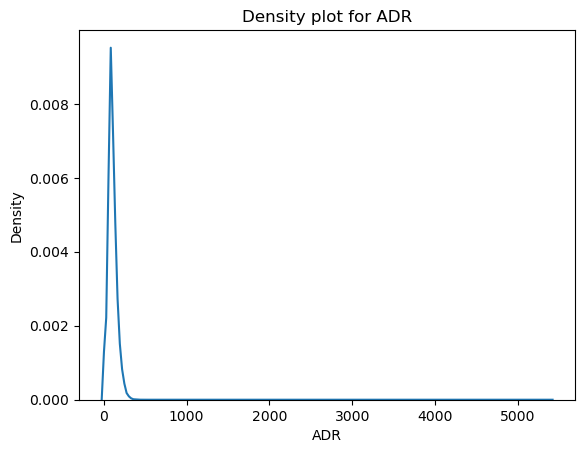

In [13]:
plt.figure()
sns.kdeplot(df["adr"])
plt.title("Density plot for ADR")
plt.xlabel("ADR")
plt.show()

# there are both negative values and very few larger positive outliers in this data so lets remove them
# since these values dont really make sense when looking at the formula for ADR
# ADR = total rooms revenue / num rooms sold

In [14]:
# removing these incorrect values
index = df[df["adr"] > 2000].index
df = df.drop(index)

index = df[df["adr"] < 0].index
df = df.drop(index)

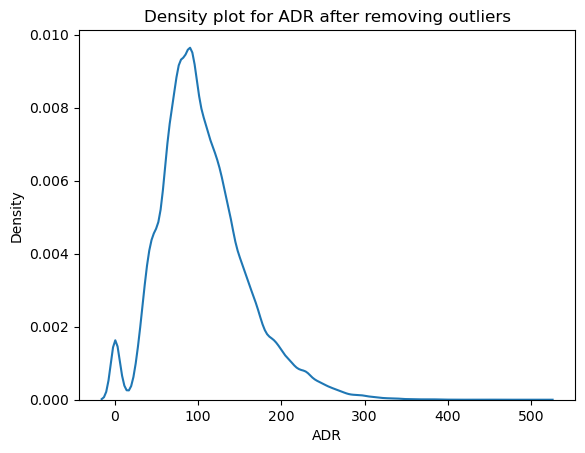

In [15]:
# lets replot the density plot
plt.figure()
sns.kdeplot(df["adr"])
plt.title("Density plot for ADR after removing outliers")
plt.xlabel("ADR")
plt.show()

In [16]:
# now lets look at categorical cols

for col in df.select_dtypes("object"):
    print("\n" + "*" * 10 + col + "*" * 10)
    display(df[col].value_counts())


**********hotel**********


City Hotel      53427
Resort Hotel    33967
Name: hotel, dtype: int64


**********arrival_date_month**********


August       11257
July         10057
May           8355
April         7908
June          7765
March         7511
October       6934
September     6690
February      6098
December      5131
November      4995
January       4693
Name: arrival_date_month, dtype: int64


**********meal**********


BB           67976
SC            9481
HB            9085
Undefined      492
FB             360
Name: meal, dtype: int64


**********country**********


PRT    27452
GBR    10432
FRA     8837
ESP     7252
DEU     5387
       ...  
MMR        1
BFA        1
CYM        1
MLI        1
KHM        1
Name: country, Length: 178, dtype: int64


**********market_segment**********


Online TA        51618
Offline TA/TO    13888
Direct           11804
Groups            4941
Corporate         4212
Complementary      702
Aviation           227
Undefined            2
Name: market_segment, dtype: int64


**********distribution_channel**********


TA/TO        69140
Direct       12987
Corporate     5081
GDS            181
Undefined        5
Name: distribution_channel, dtype: int64


**********reserved_room_type**********


A    56550
D    17398
E     6049
F     2823
G     2052
B      999
C      915
H      596
L        6
P        6
Name: reserved_room_type, dtype: int64


**********assigned_room_type**********


A    46312
D    22432
E     7195
F     3627
G     2498
C     2165
B     1820
H      705
I      357
K      276
P        6
L        1
Name: assigned_room_type, dtype: int64


**********deposit_type**********


No Deposit    86250
Non Refund     1037
Refundable      107
Name: deposit_type, dtype: int64


**********customer_type**********


Transient          71985
Transient-Party    11726
Contract            3139
Group                544
Name: customer_type, dtype: int64


**********reservation_status**********


Check-Out    63370
Canceled     23010
No-Show       1014
Name: reservation_status, dtype: int64


**********reservation_status_date**********


2016-02-14    211
2017-05-25    205
2015-10-21    199
2016-10-06    196
2016-03-28    196
             ... 
2015-02-27      1
2015-03-11      1
2015-03-12      1
2015-03-18      1
2015-02-02      1
Name: reservation_status_date, Length: 926, dtype: int64

In [17]:
# notice top10 countries make up > 80% of data, similar sort of thing happening with other categorical columns
df["country"].value_counts()[:10].sum()

71429

In [18]:
df.nunique()

hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            178
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
agent                              334
company                            353
days_in_waiting_list     

In [19]:
# for the meal column undefined and SC are meant to be the same thing
df["meal"] = df["meal"].replace({"Undefined" : "SC"})
# but other than this all object columns appear to have the correct values in them

In [20]:
indexes = df[df["adults"] + df["children"] + df["babies"] <= 0].index # 150 of these
# lets remove these columns with no one in the room
df = df.drop(indexes)

In [21]:
indexes = df[df["stays_in_weekend_nights"] + df["stays_in_week_nights"] <= 0].index # 650 of these
# lets remove columns where the person is staying for 0 days
df = df.drop(indexes)

In [22]:
# lets convert any columns that are float64 to int64 since the columns are actually integer valued EXCEPT ADR
float_cols = df.select_dtypes(np.float64).columns.tolist()
float_cols.remove("adr")
df[float_cols] = df[float_cols].astype(np.int64)

In [23]:
# reindex after all the dropping of rows
df = df.reindex()

In [24]:
# move target col to the end
order = df.columns.tolist()
order.remove("is_canceled")
order.append("is_canceled") 
df = df[order]

In [25]:
# beautiful and clean
df.head().T

,2,3,4,6,7
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel
lead_time,7,13,14,0,9
arrival_date_year,2015,2015,2015,2015,2015
arrival_date_month,July,July,July,July,July
arrival_date_week_number,27,27,27,27,27
arrival_date_day_of_month,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,1,1,2,2,2
adults,1,1,2,2,2
children,0,0,0,0,0


## Analysis of the data

In [26]:
# lets do some univariate analysis

# first we need to sort out the date columns
# to make it easier to plot data especially for time series

# lets ordinal encode arrival date month
df["arrival_date_month"] = pd.to_datetime(df["arrival_date_month"], format="%B").dt.month

# and lets add an arrival date datetime col for making timeseries
df["arrival_date_dt"] = pd.to_datetime(dict(year=df["arrival_date_year"], month=df["arrival_date_month"], day=df["arrival_date_day_of_month"]))

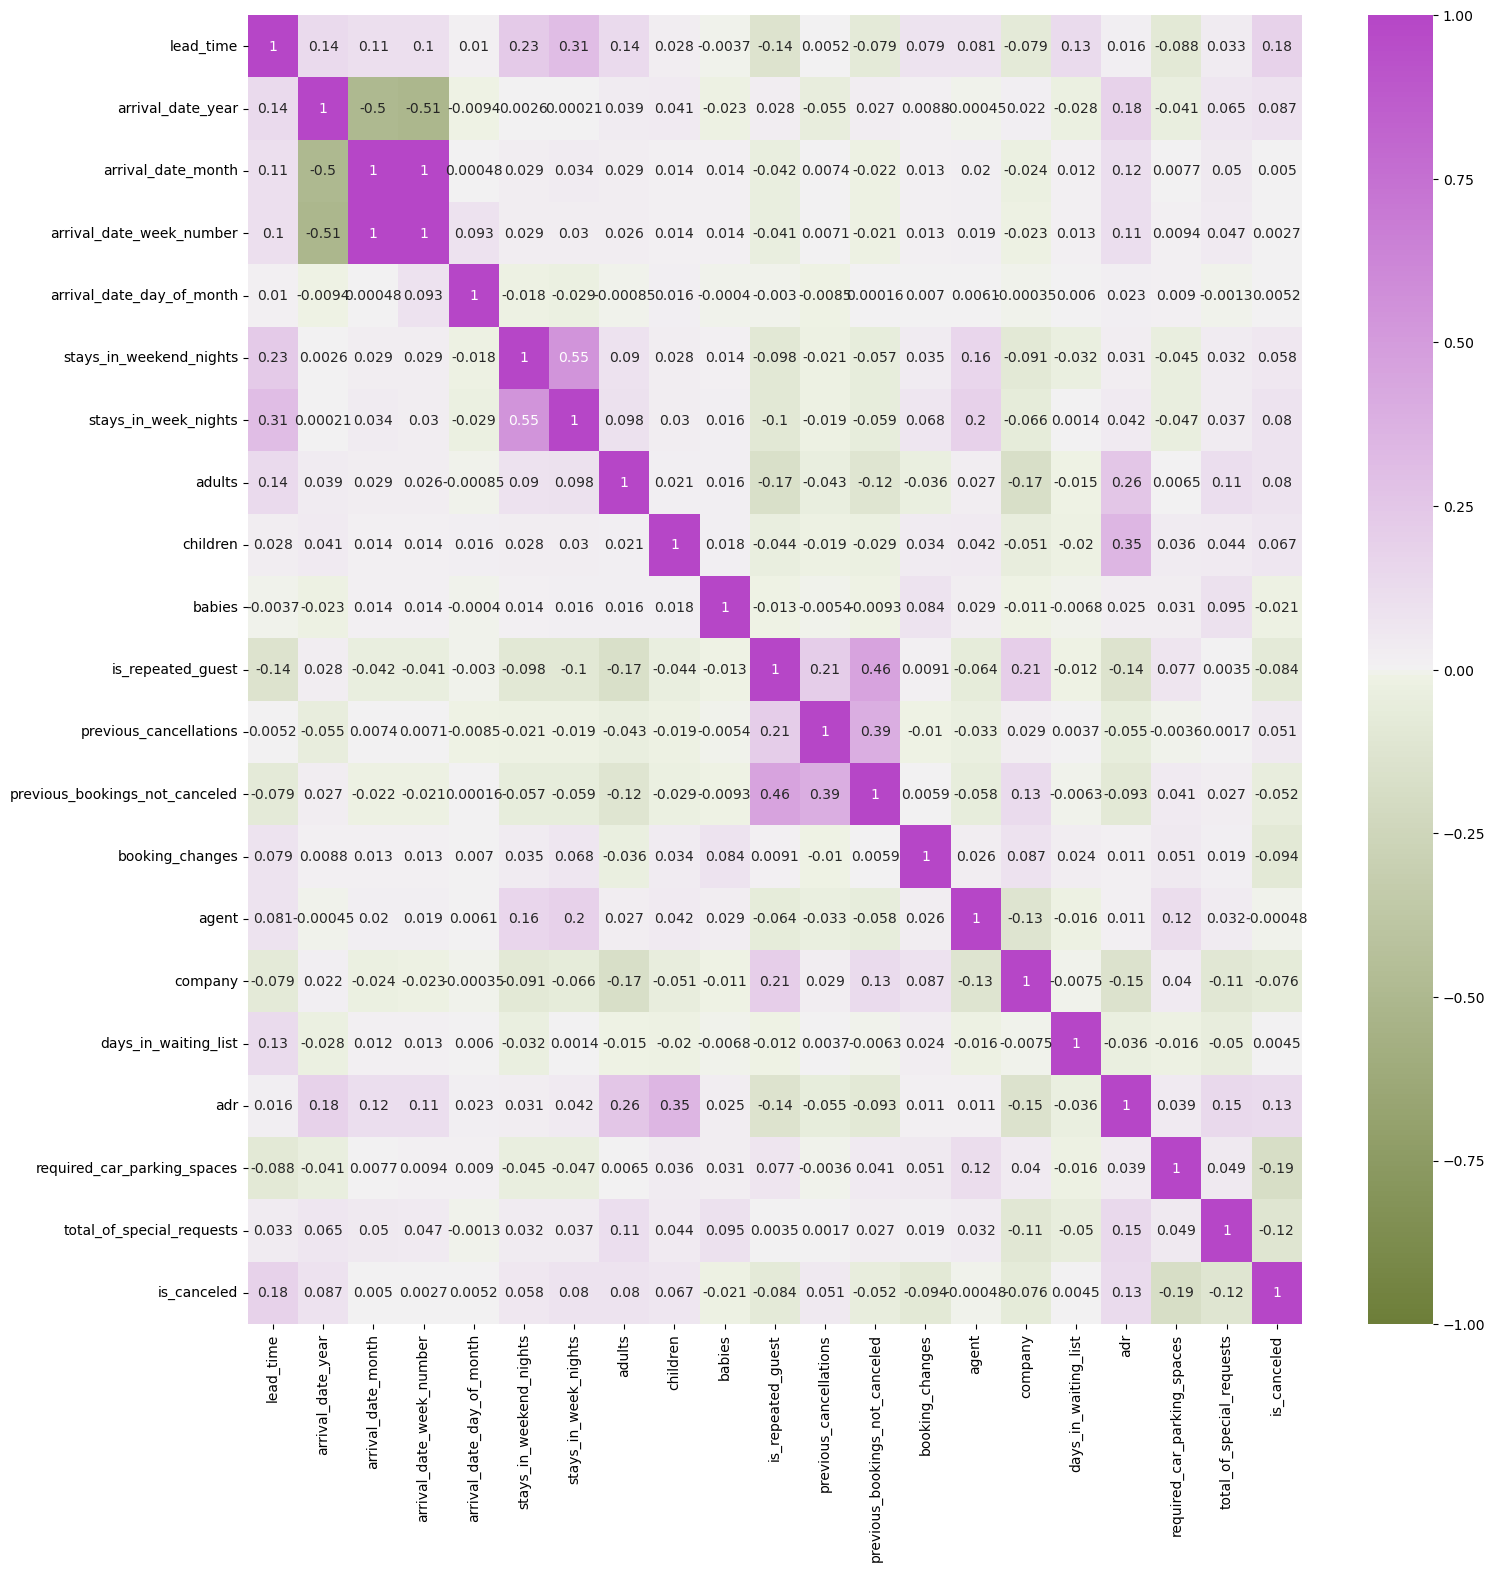

In [27]:
# lets plot a correlation map to see if any of the features are related

plt.figure(figsize=(17, 17))
palette = sns.diverging_palette(100, 300, as_cmap=True)
corr = df.select_dtypes(np.number).corr()
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap=palette)
plt.show()

# we notice from this:
# is canceled is most highly correlated with required car spaces (0.18 correlation), total special requests, adr, booking changes, repeated guest (all with > 0.09 correlation)
# a lot of the other features that have > 0.15 correlation seem to be related in a casual way i.e whether some one is a previous guest and how many cancelations theyve had

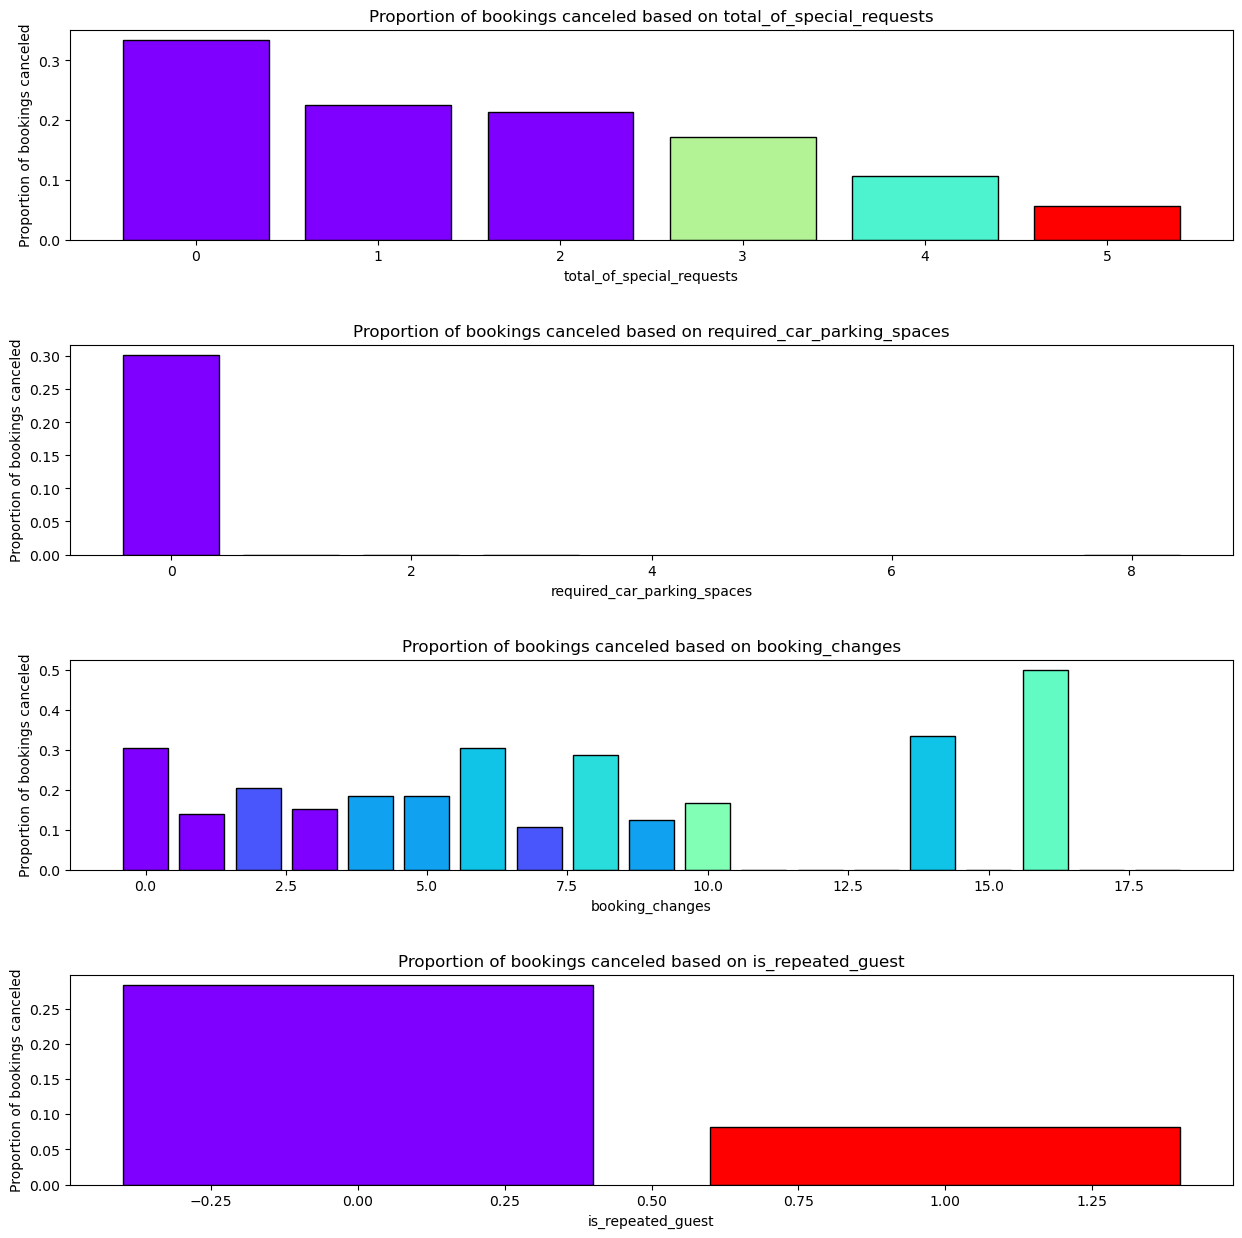

In [28]:
# bar chart of selected cols against proportion of these bookings that have cancelations

cols = ["total_of_special_requests", "required_car_parking_spaces", "booking_changes", "is_repeated_guest"]

# creating a subplot to plot bar charts for each of the cols in above list
fig, axs = plt.subplots(len(cols))
for i, col in enumerate(cols):
    data = df.groupby(col)["is_canceled"].mean()
    colours = plt.cm.rainbow(np.linspace(0, 1, len(data)))
    random.shuffle(colours)
    axs[i].bar(data.index, data, color=colours, edgecolor="black")
    axs[i].set_title(f"Proportion of bookings canceled based on {col}")
    axs[i].set_ylabel("Proportion of bookings canceled")
    axs[i].set_xlabel(f"{col}")
    fig.set_size_inches(15, 15)
    fig.subplots_adjust(hspace=0.5)
plt.show()

# if 1 or more parking spaces are requested then, in the entire dataset, none of these bookings have been canceled
# this would be good to add as a feature

# and with special requests, as soon as someone requests anything the cancelation rate goes right down, and decreases the more requests there are

# as soon as someone makes a change to their booking the cancelation proportion decreases (generally but not always), note there are fewer datapoints with lots of booking changes

# and as expected, repeated guests are less likely to cancel

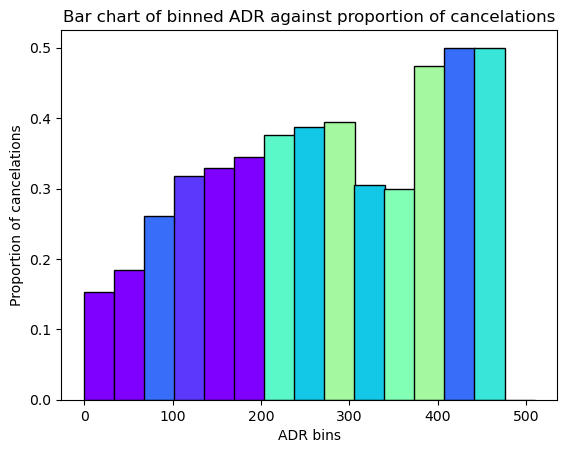

In [29]:
# bar chart of ADR divided into bins against proportion of cancelations

# choose bins
bins = pd.cut(df["adr"], bins=15, retbins=True)[-1] # array of bin boundaries
# find midpoint of every bin
pairwise_mean_bins = (bins[1:] + bins[:-1]) / 2
# width of each bin for use when plotting
bin_width = bins[1] - bins[0]
# array to store proportion of cancelations
props = []

for i in range(len(bins) - 1):
    # group data by adr bins, calculate proportion of cancelations
    # then add to props list
    rows_between = df[df["adr"].between(bins[i], bins[i+1])]
    rows_between_and_canceled = df[(df["adr"].between(bins[i], bins[i+1])) & (df["is_canceled"] == 1)]
    total = rows_between.shape[0]
    canceled_total = rows_between_and_canceled.shape[0]
    props.append(canceled_total / total)

# create bar chart
fig, ax = plt.subplots()
colours = plt.cm.rainbow(np.linspace(0, 1, len(bins) - 1))
random.shuffle(colours)
ax.bar(pairwise_mean_bins, props, width=bin_width, edgecolor="black", color=colours)
ax.set_title("Bar chart of binned ADR against proportion of cancelations")
ax.set_xlabel("ADR bins")
ax.set_ylabel("Proportion of cancelations")
plt.show()

# seems to suggest the higher the ADR the higher proportion of cancelations (exluding the data between 310 and 370 ADR)
# after inverstigation of the data, realised there are not many samples with > 300 ADR, so if we just consider the data before 300 ADR
# then our correlation between ADR and proportion of cancelations seems much stronger
# ADR = total room revenue / num rooms sold
# the most logical explanation for this correlation i can see is
# people with cheaper rooms are more likely to cancel, and the ADR goes up when someone cancels a cheap room
# hence it may be a good idea to look at cancelations and room types

Most popular room types in order: ['A', 'D', 'E', 'F', 'G', 'C', 'B', 'H', 'I', 'K', 'L']


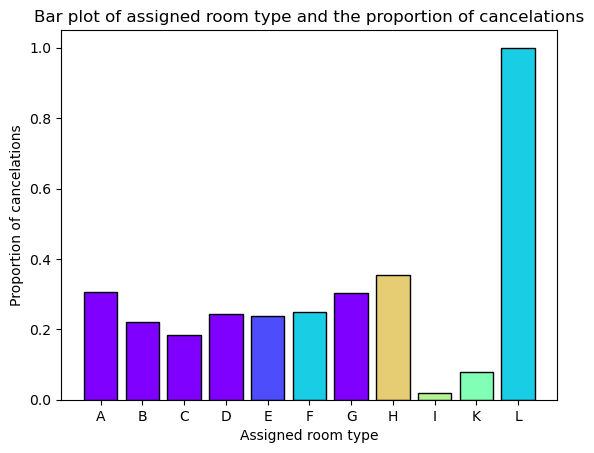

In [30]:
# bar chart of cancelations vs assigned room types

print("Most popular room types in order: {}".format(df["assigned_room_type"].value_counts().index.tolist()))

data = df.groupby("assigned_room_type")["is_canceled"].mean()
fig, ax = plt.subplots()
colours = plt.cm.rainbow(np.linspace(0, 1, len(data)))
random.shuffle(colours)
ax.bar(data.index, data, color=colours, edgecolor="black")
ax.set_title("Bar plot of assigned room type and the proportion of cancelations")
ax.set_xlabel("Assigned room type")
ax.set_ylabel("Proportion of cancelations")
plt.show()

# not loads to take from this graph, note: barely any people have booked into rooms I, K, L

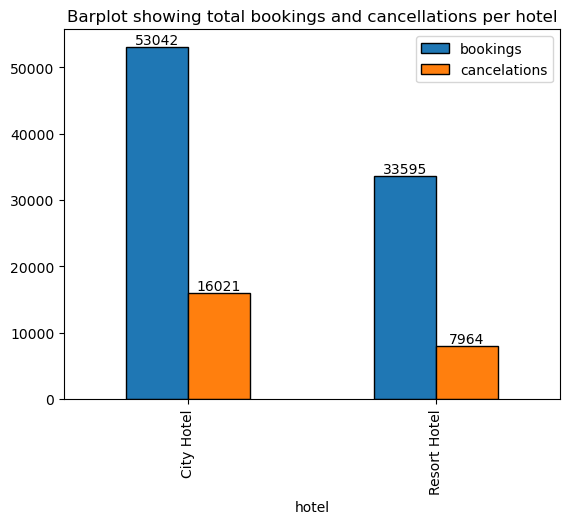

In [31]:
# lets look at bookings and cancellations per hotel
data = df.groupby("hotel")["is_canceled"].agg(["count", "sum"])
data.columns = ["bookings", "cancelations"]
# count is total bookings, sum is total cancelations

fig, ax = plt.subplots()
bar_container = data.plot(kind="bar", ax=ax, edgecolor="black")

for i in ax.containers:
    ax.bar_label(i)

ax.set_title("Barplot showing total bookings and cancellations per hotel")
plt.show()

# city hotel gets more bookings overall, and a larger proportion of cancelations

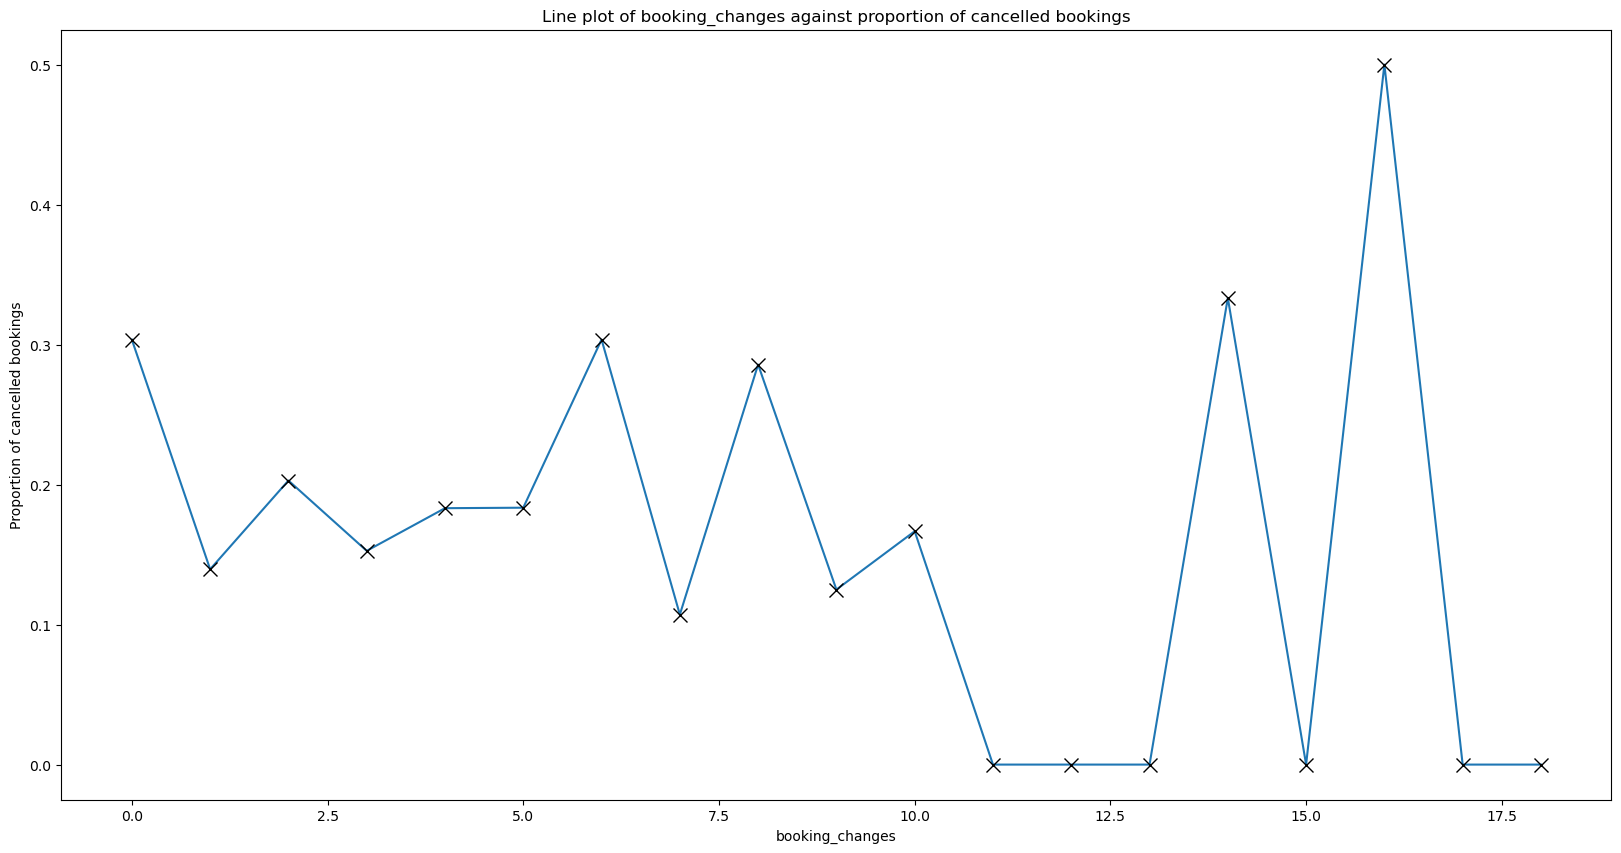

In [32]:
# line graph of num booking changes vs canceled bookings

col = "booking_changes"
plt.figure(figsize=(20, 10))
data = df.groupby(col)["is_canceled"].agg(["mean", "count"])
plt.plot(data.index.tolist(), data["mean"], marker="x", mec="k", markersize=10)

plt.title(f"Line plot of {col} against proportion of cancelled bookings")
plt.ylabel("Proportion of cancelled bookings")
plt.xlabel(col)
plt.show()

# take this graph with a grain of salt booking changes > 10 make up a small proportion of the bookings
# ignoring the outliers (> 10 booking changes) it appears the more booking changes, the less likely someone is to cancel

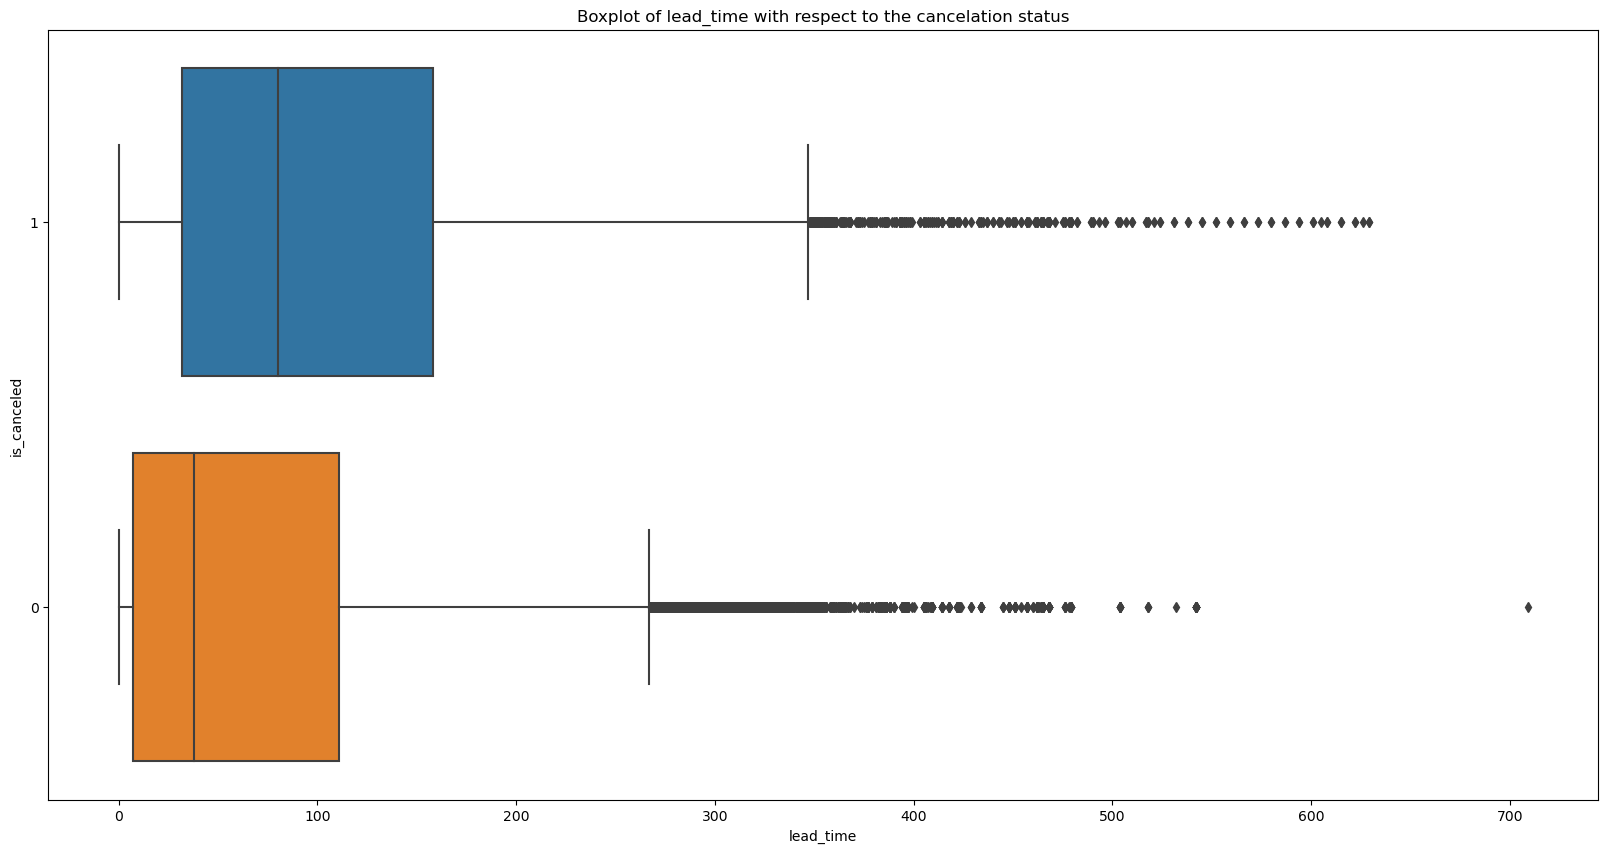

In [33]:
# lets try a box plot approach
col = "lead_time"

plt.figure(figsize=(20, 10))
sns.boxplot(data=df, x=df[col], y=df["is_canceled"], orient="h", order=[1, 0])
plt.title(f"Boxplot of {col} with respect to the cancelation status")
plt.show()

# shows that the further someone books in advance the more likely they are to cancel

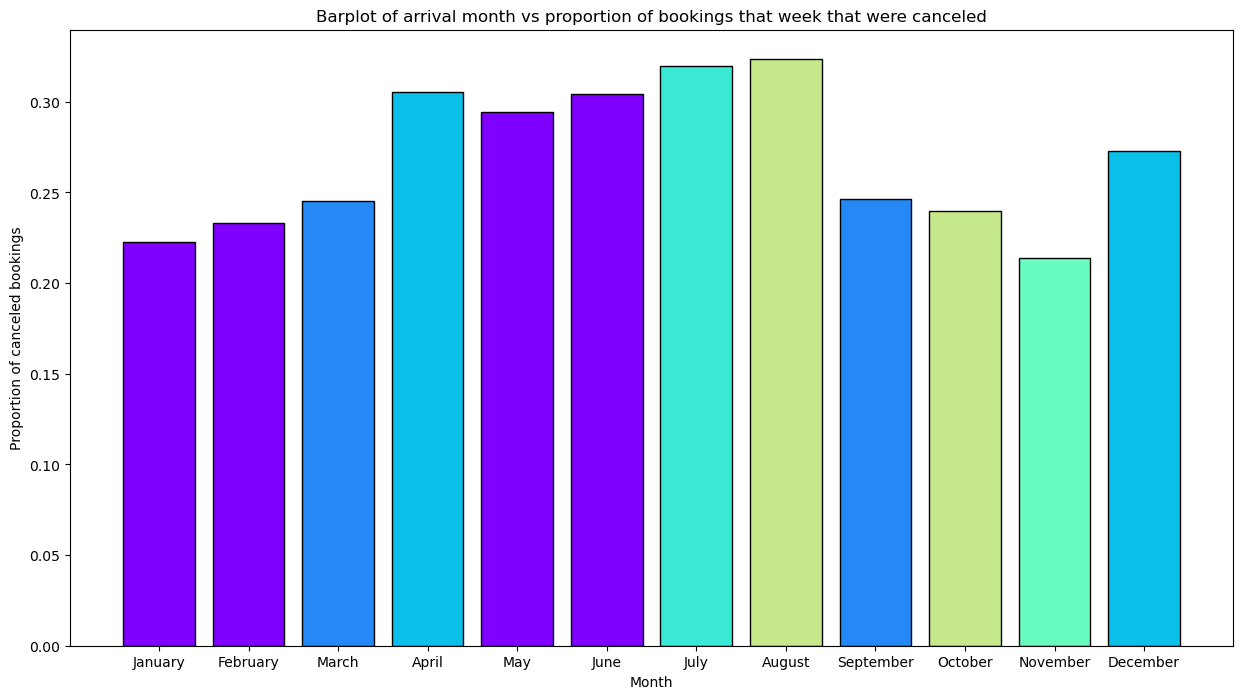

In [34]:
# barplot of arrival data month vs number or proportion of bookings in that week that where cancellations

week_data = df.groupby("arrival_date_month")["is_canceled"].agg(["mean"])
colours = plt.cm.rainbow(np.linspace(0, 1, len(week_data)))
random.shuffle(colours)

plt.figure(figsize=(15, 8))
plt.bar(week_data.index, week_data["mean"], edgecolor="black", color=colours)
plt.title("Barplot of arrival month vs proportion of bookings that week that were canceled")
plt.xticks(ticks=week_data.index, labels=calendar.month_name[1:])
plt.xlabel("Month")
plt.ylabel("Proportion of canceled bookings")
plt.show()


# distribution seems to suggest summer months have a higher proportion of cancelations, while there are much fewer in the early year

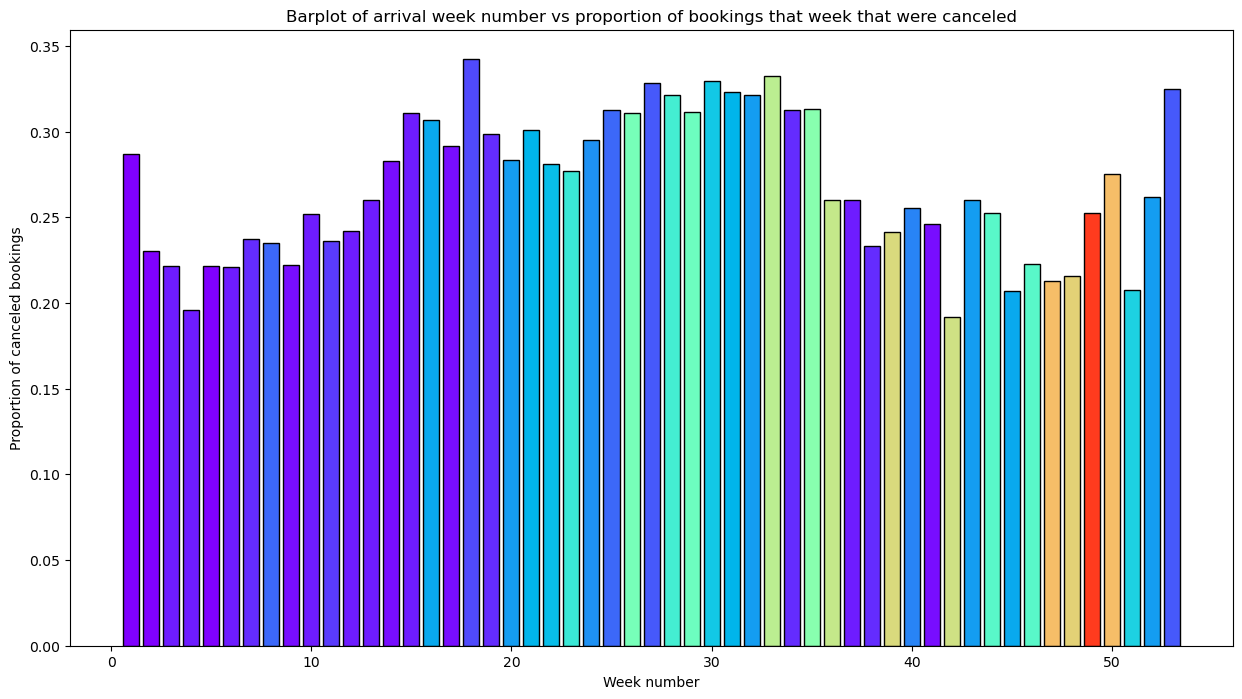

In [35]:
# barplot of arrival data week number vs number or proportion of bookings in that week that where cancellations

week_data = df.groupby("arrival_date_week_number")["is_canceled"].agg(["mean"])
colours = plt.cm.rainbow(np.linspace(0, 1, len(week_data)))
random.shuffle(colours)
plt.figure(figsize=(15, 8))
plt.bar(week_data.index, week_data["mean"], edgecolor="black", color=colours)
plt.title("Barplot of arrival week number vs proportion of bookings that week that were canceled")
plt.xlabel("Week number")
plt.ylabel("Proportion of canceled bookings")
plt.show()

# distribution seems to peak in the summer months and trail off towards winter and spring so a higher proportion of cancelations in summe months

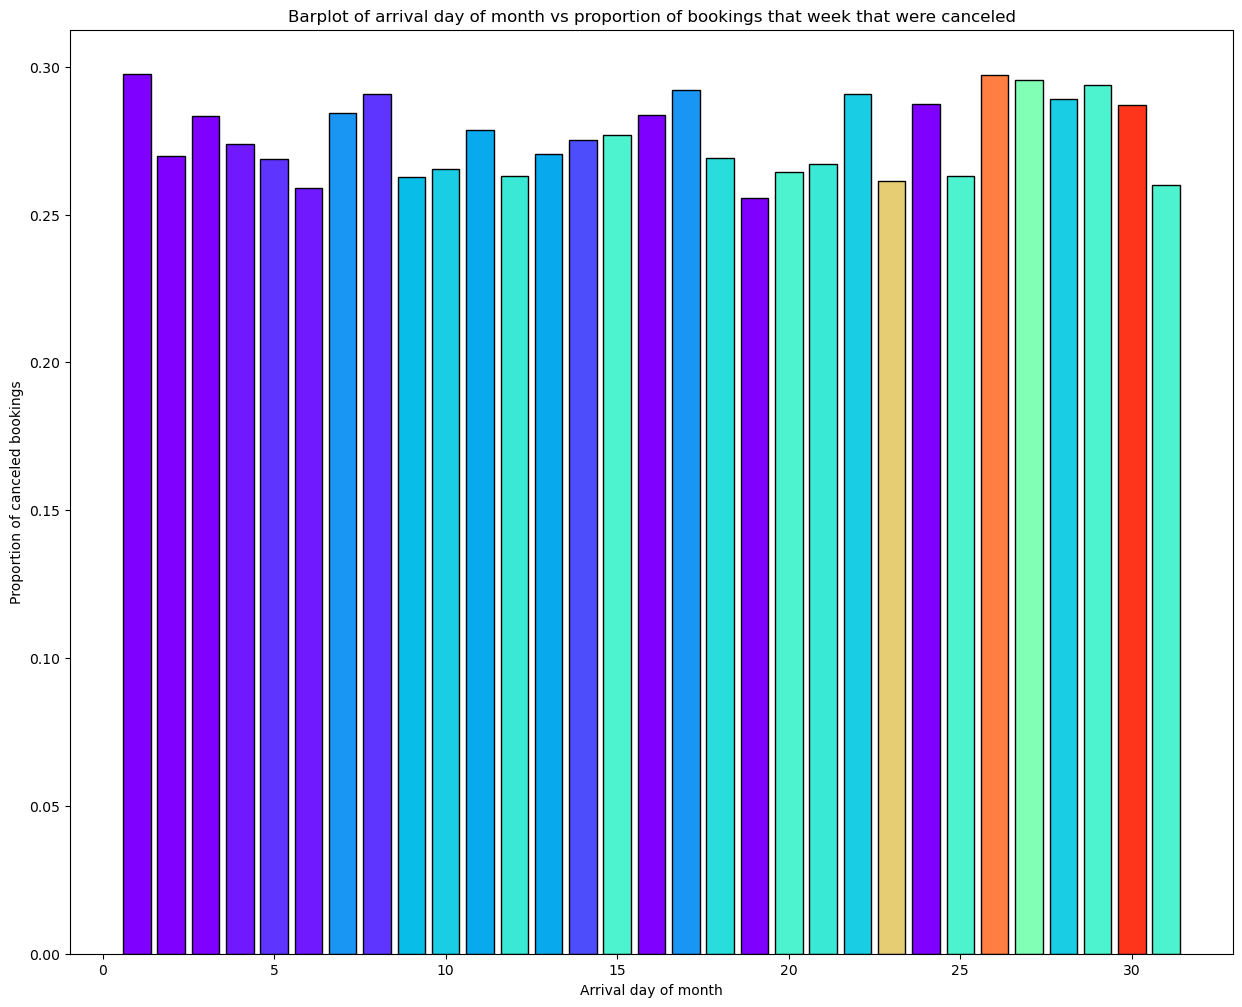

In [36]:
# barplot of arrival data day vs number or proportion of bookings in that week that where cancellations

week_data = df.groupby("arrival_date_day_of_month")["is_canceled"].agg(["mean"])
colours = plt.cm.rainbow(np.linspace(0, 1, len(week_data)))
random.shuffle(colours)
plt.figure(figsize=(15, 12))
plt.bar(week_data.index, week_data["mean"], color=colours, edgecolor="black")
plt.title("Barplot of arrival day of month vs proportion of bookings that week that were canceled")
plt.xlabel("Arrival day of month")
plt.ylabel("Proportion of canceled bookings")
plt.show()

# seems pretty random, not sure what information can be taken from this

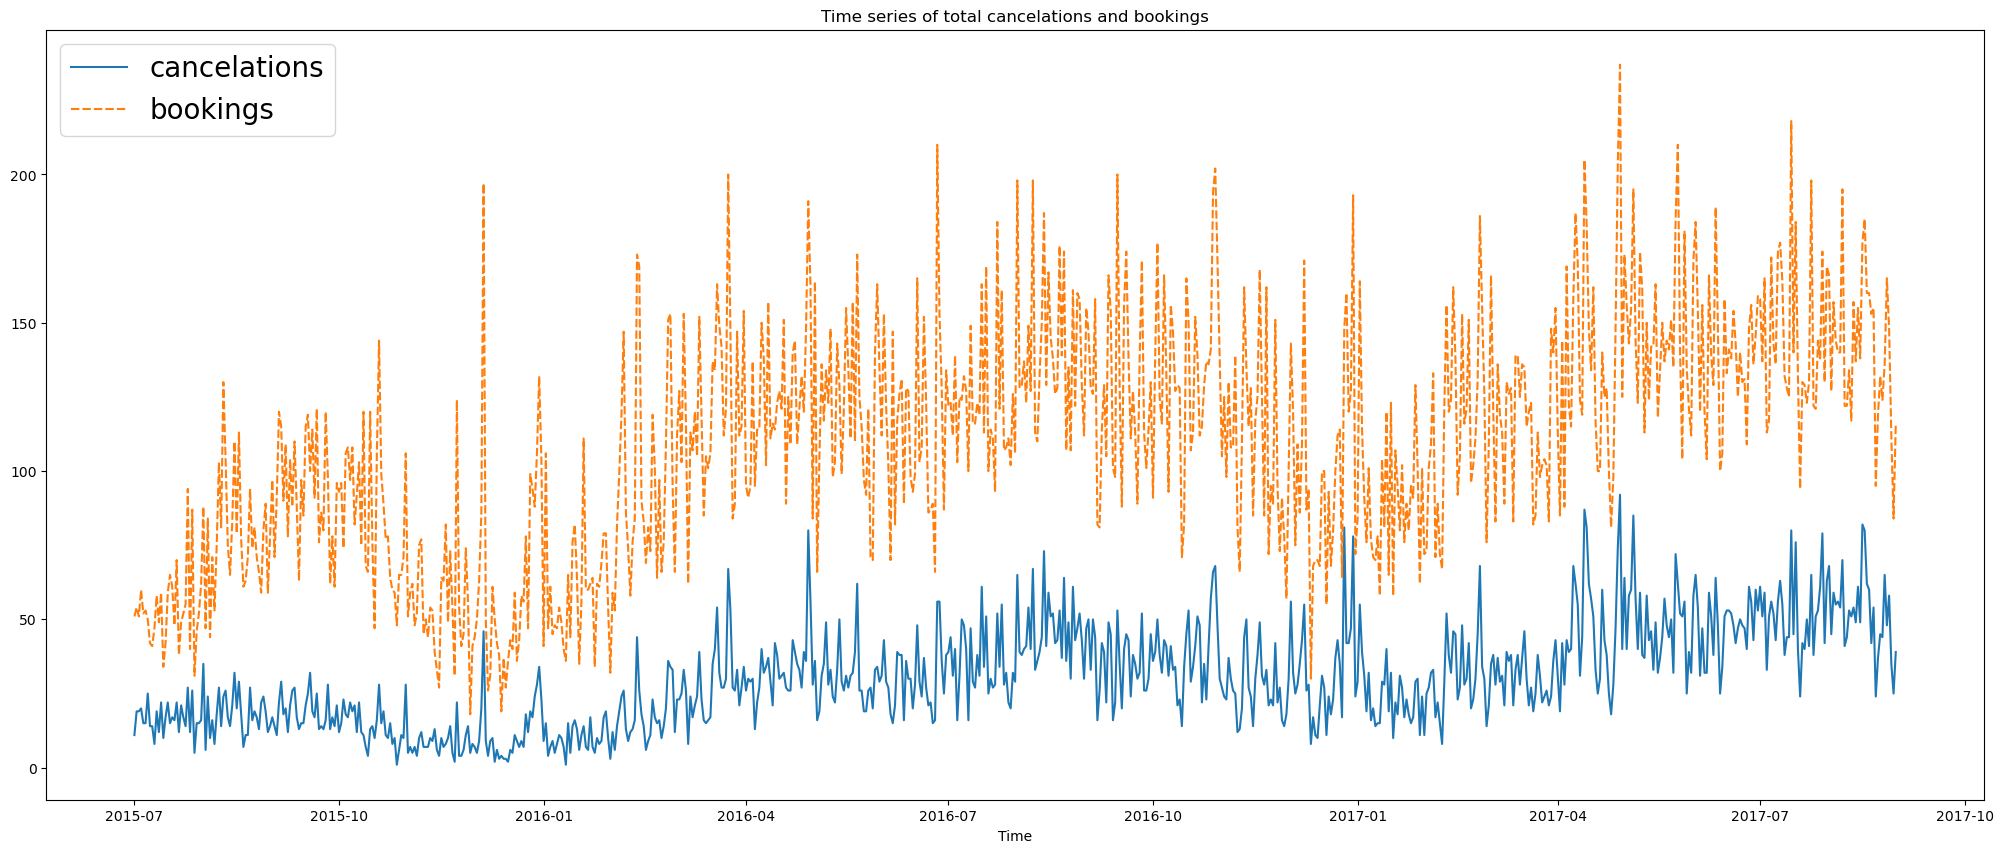

In [37]:
# now lets start to look at time infomation together and plot some time series

time_data = df.groupby("arrival_date_dt")["is_canceled"].agg(["sum", "count"])
time_data.columns = ["cancelations", "bookings"]

fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sns.lineplot(time_data)
ax.set_xlabel("Time")
ax.set_title("Time series of total cancelations and bookings")
ax.legend(fontsize=20)
plt.show()

# quite challenging to see some of the information without seeing this graph larger, may be a good idea to view 1 year at a time for example
# but the trend of bookings and cancelations follow each other

10:05:18 - cmdstanpy - INFO - Chain [1] start processing
10:05:19 - cmdstanpy - INFO - Chain [1] done processing


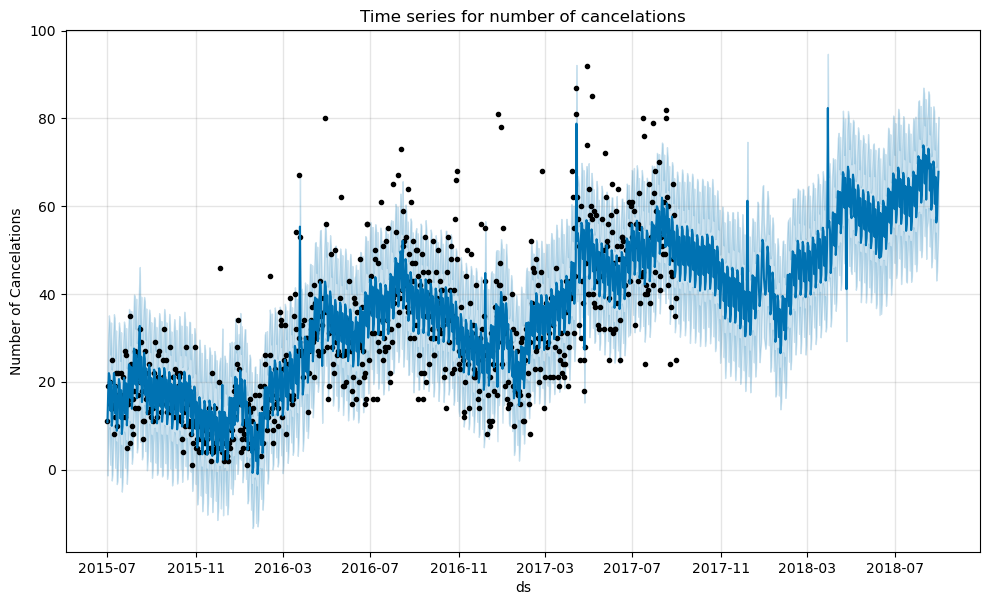

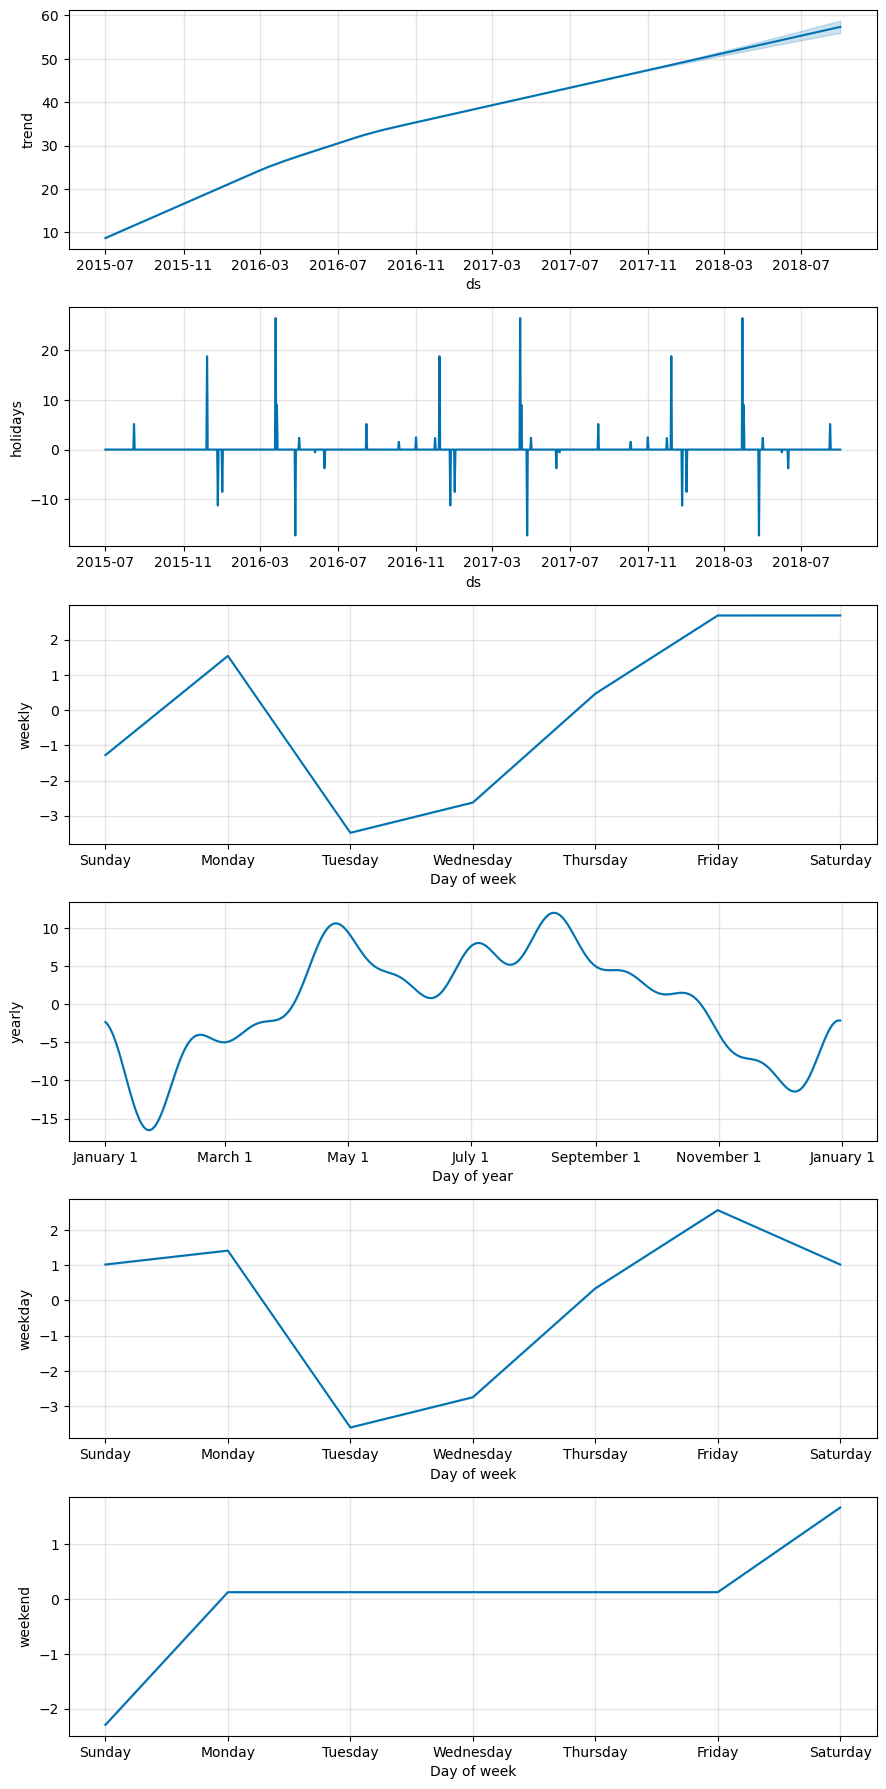

In [38]:
# lets use prophet to have a look at future time series data
# firstly looking at num cancelations over time

time_data = df.groupby("arrival_date_dt")["is_canceled"].sum()
num_canceled_df = pd.DataFrame({"ds" : time_data.index, 
                               "y" : time_data})

# adding weekend seasonality columns
num_canceled_df["weekend"] = num_canceled_df["ds"].apply(lambda date: date.weekday() in {5, 6})
num_canceled_df["weekday"] = ~num_canceled_df["weekend"]

# adding portugese holidays
# this returns a dict with keys being datetimes and values being name of holiday
portugal_hols = holidays.Portugal(years=[2015, 2016, 2017, 2018, 2019])
portugal_hols = pd.DataFrame({"holiday" : portugal_hols.values(),
                             "ds" : portugal_hols.keys()})
portugal_hols["ds"] = pd.to_datetime(portugal_hols["ds"])

p = Prophet(holidays=portugal_hols)
p.add_seasonality(name="weekend", period=7, fourier_order=3, condition_name="weekend")
p.add_seasonality(name="weekday", period=7, fourier_order=3, condition_name="weekday")
p.fit(num_canceled_df)

# makes the extra dates for the dataframe and add weekend/weekday cols
future = p.make_future_dataframe(periods=365)
future["weekend"] = future["ds"].apply(lambda date: date.weekday() in {5, 6})
future["weekday"] = ~future["weekend"]

# does the predictions
forecast = p.predict(future) 

# assigned to a variable to stop it plotting twice
fig1 = p.plot(forecast)
ax1 = fig1.gca()
ax1.set_title("Time series for number of cancelations")
ax1.set_ylabel("Number of Cancelations")
fig2 = p.plot_components(forecast)

10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing


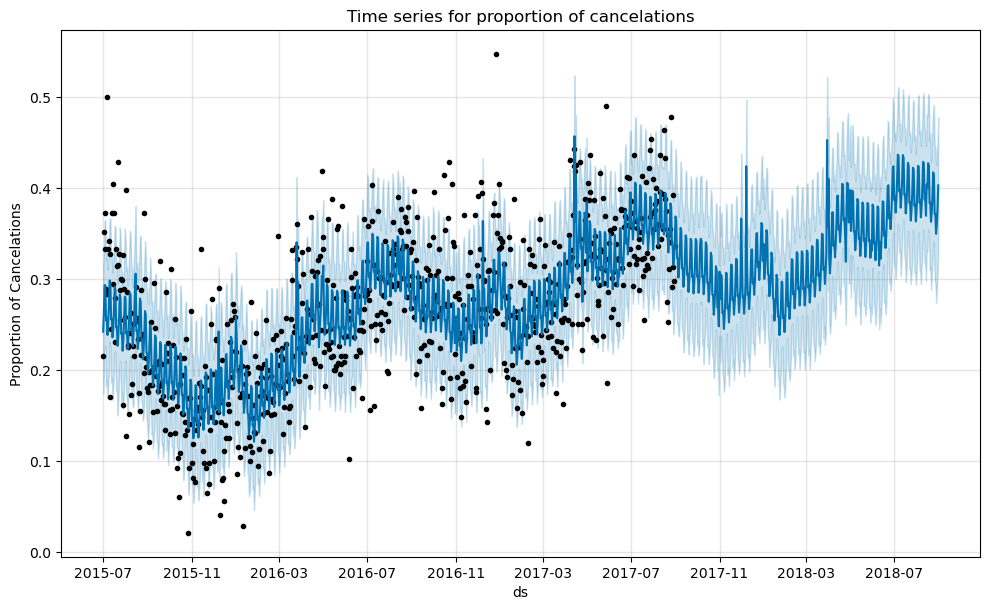

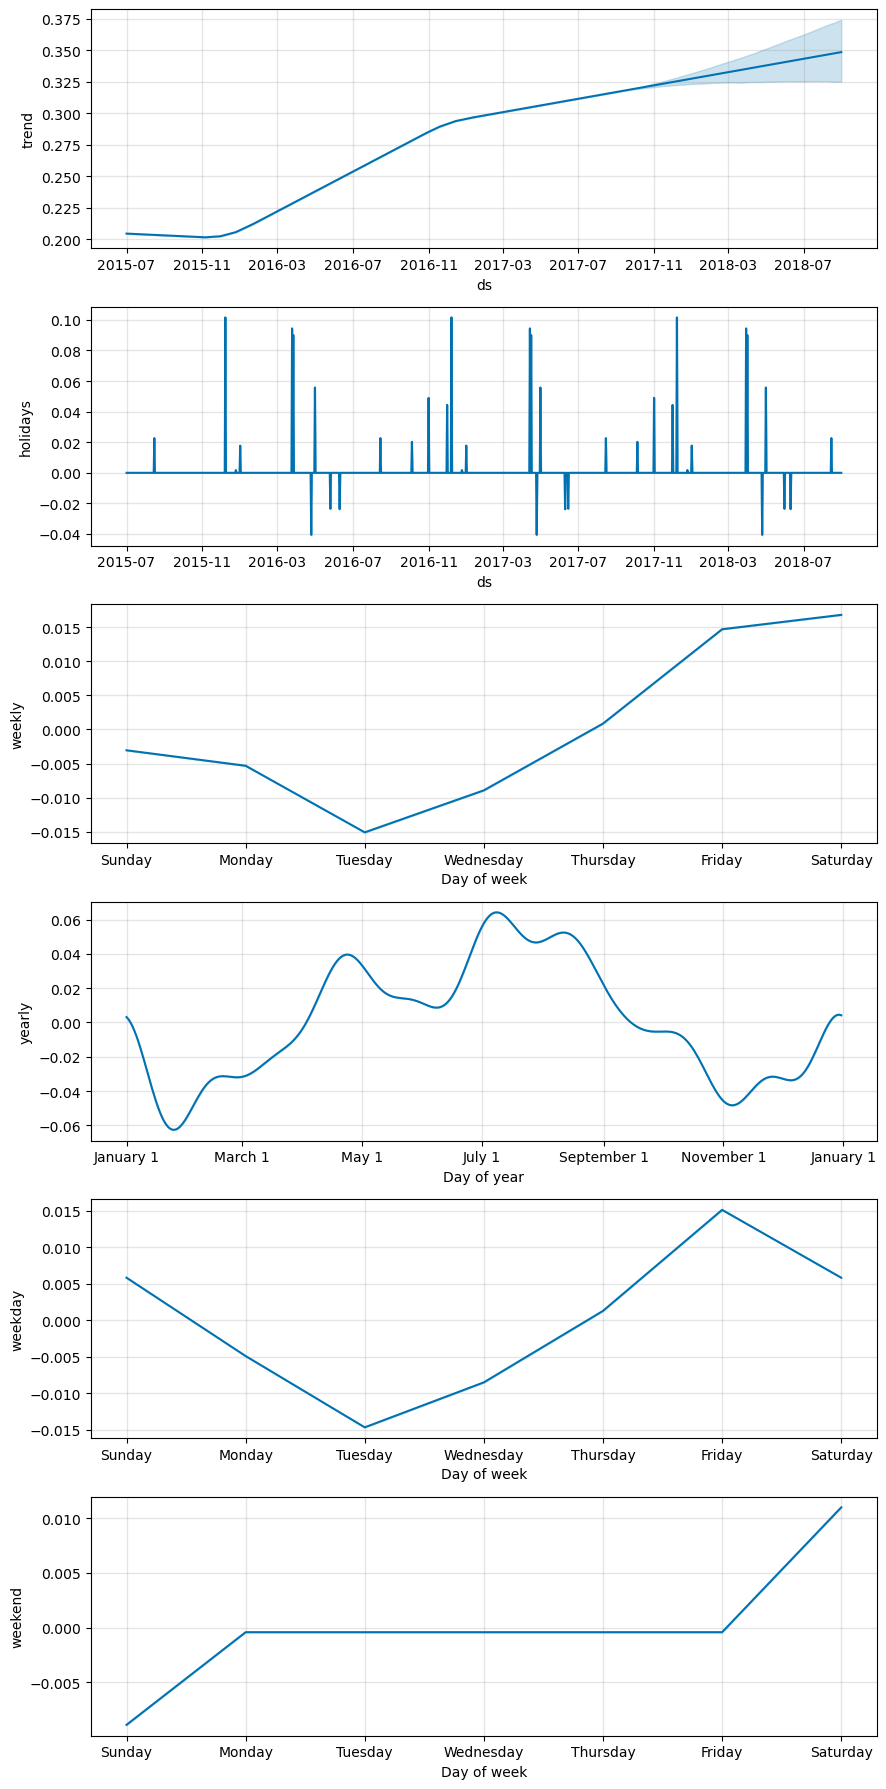

In [39]:
# lets look at proportion of cancelations over time and do analysis for all the time series at the end

time_data = df.groupby("arrival_date_dt")["is_canceled"].mean()
prop_canceled_df = pd.DataFrame({"ds" : time_data.index, 
                               "y" : time_data})

# adding weekend seasonality columns
prop_canceled_df["weekend"] = prop_canceled_df["ds"].apply(lambda date: date.weekday() in {5, 6})
prop_canceled_df["weekday"] = ~prop_canceled_df["weekend"]

# adding portugese holidays
# this returns a dict with keys being datetimes and values being name of holiday
portugal_hols = holidays.Portugal(years=[2015, 2016, 2017, 2018, 2019])
portugal_hols = pd.DataFrame({"holiday" : portugal_hols.values(),
                             "ds" : portugal_hols.keys()})
portugal_hols["ds"] = pd.to_datetime(portugal_hols["ds"])

p = Prophet(holidays=portugal_hols)
p.add_seasonality(name="weekend", period=7, fourier_order=3, condition_name="weekend")
p.add_seasonality(name="weekday", period=7, fourier_order=3, condition_name="weekday")
p.fit(prop_canceled_df)

# makes the extra dates for the dataframe and add weekend/weekday cols
future = p.make_future_dataframe(periods=365)
future["weekend"] = future["ds"].apply(lambda date: date.weekday() in {5, 6})
future["weekday"] = ~future["weekend"]

# does the predictions
forecast = p.predict(future) 

# assigned to a variable to stop it plotting twice
fig1 = p.plot(forecast)
ax1 = fig1.gca()
ax1.set_title("Time series for proportion of cancelations")
ax1.set_ylabel("Proportion of Cancelations")
fig2 = p.plot_components(forecast)

In [40]:
# analysis from time series
# main takeaway is that there are spikes of increased cancelations/increased proportions of cancelations near national holidays in portugal
# specifically near christmas and easter so lets build some new features into the dataset
# i.e is_national_holiday, is_christmas, is_easter, distance_from_national_holiday etc

# from the time series forecasting it appeared total and proportion of cancelations are increasing and are predicted to increase over time

# in terms of monthly trends, the highest proportion of cancelations seem to be in the summer months
# this could be because people that stay in the hotel not in summer months are there for alternative reasons i.e business not holiday 
# so are less likely to cancel, it will be a good idea to look at the market segment guests are from

# in terms of weekly trends, there are a smaller proportion of mid week cancelations and this proportion increases as the weekend gets closer
# once again this could be due to people travelling during the week being there for different reasons than people arriving on weekends (i.e working during the week)
# considering adding feature like weekday_only_stay, weekend_only_stay, stay_length

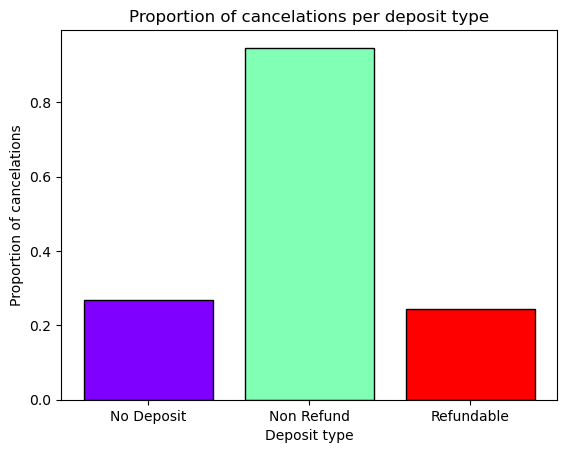

In [41]:
# deposit type vs proportion of cancelations
data = df.groupby("deposit_type")["is_canceled"].mean()
fig, ax = plt.subplots()
colours = plt.cm.rainbow(np.linspace(0, 1, len(data)))
random.shuffle(colours)
ax.bar(data.index, data, edgecolor="black", color=colours)
ax.set_title("Proportion of cancelations per deposit type")
ax.set_ylabel("Proportion of cancelations")
ax.set_xlabel("Deposit type")
plt.show()

# very odd, people with non refundable deposits seem to be canceling the most, although there are only 1000 bookings of this kind

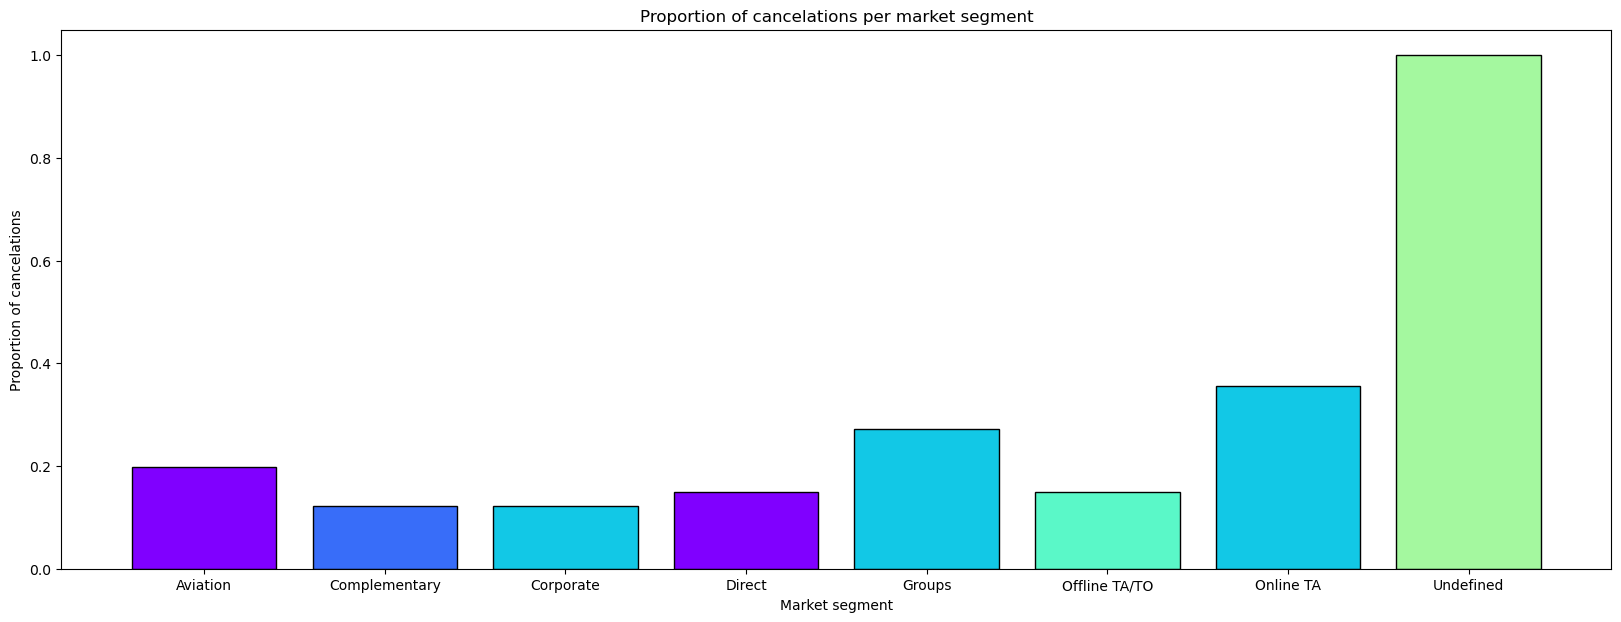

In [42]:
# market segment vs proportion of cancelations

data = df.groupby("market_segment")["is_canceled"].mean()
fig, ax = plt.subplots(figsize=(20, 7))
colours = plt.cm.rainbow(np.linspace(0, 1, len(data)))
random.shuffle(colours)
ax.bar(data.index, data, color=colours, edgecolor="black")
ax.set_title("Proportion of cancelations per market segment")
ax.set_ylabel("Proportion of cancelations")
ax.set_xlabel("Market segment")
plt.show()

# note undefined only contains 2 bookings
# but we can see that certain market segments have a higher chance of cancelation i.e groups and online travel agencys

In [43]:
# may do some multivariate analysis later but i have enough information now to code my model
# may also explore plots with some log transformed data
# may also use plotly

## Feature engineering

In [44]:
df.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_canceled,arrival_date_dt
2,Resort Hotel,7,2015,7,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,0,2015-07-01
3,Resort Hotel,13,2015,7,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,0,2015-07-01
4,Resort Hotel,14,2015,7,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,0,Transient,98.0,0,1,Check-Out,2015-07-03,0,2015-07-01
6,Resort Hotel,0,2015,7,27,1,0,2,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,0,0,0,Transient,107.0,0,0,Check-Out,2015-07-03,0,2015-07-01
7,Resort Hotel,9,2015,7,27,1,0,2,2,0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303,0,0,Transient,103.0,0,1,Check-Out,2015-07-03,0,2015-07-01


In [45]:
# convert company column to simply an indicator whether it was booked through a company
# do same with agent but we will also onehot encode that column
df["booked_through_company"] = df["company"].apply(lambda x: 0 if x == 0 else 1)
df["booked_through_agent"] = df["agent"].apply(lambda x: 0 if x == 0 else 1)

In [46]:
# convert some data in columns to 'Other' that are infrequent

def replace_with_other(col, top_x):
    """For a given column of the dataframe converts anything
    not in the top x most frequent values for that column to 'Other'"""
    most_freq = df[col].value_counts()[:top_x]
    df[col] = df[col].apply(lambda x: x if x in most_freq else "Other")


replace_with_other("country", 10)
replace_with_other("market_segment", 4)
replace_with_other("distribution_channel", 2)
replace_with_other("reserved_room_type", 3)
replace_with_other("assigned_room_type", 3)
replace_with_other("agent", 3)
df["agent"] = df["agent"].astype("str") # this will stop issues when one hot encoding (mixed types)

In [47]:
# one hot encoding the following cols and adding appropriate column names

cols_to_encode = ["hotel", "meal", "country", "market_segment", "distribution_channel",
                  "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type", "agent"]
onehot_enc = OneHotEncoder(sparse_output=False)
enc_array = onehot_enc.fit_transform(df[cols_to_encode].values)
col_names = onehot_enc.get_feature_names_out(cols_to_encode)
df[col_names] = enc_array

In [52]:
# adding the following features
# indicator whether someone has requested any car parking spaces
# distance to nearest national holiday (portugal), christmas and easter
# there are two sets of functions, one set calculate the nearest holiday past or future
# the other only in the future direction
# indicators whether hotel stay is weekday or weekend only
# holiday length

binarizer = Binarizer(threshold=0.9)
df["requested_car_parking"] = binarizer.fit_transform(df["required_car_parking_spaces"].values.reshape(-1, 1))

df["stay_length"] = df["stays_in_week_nights"] + df["stays_in_weekend_nights"]
df["weekend_only_stay"] = df["stays_in_week_nights"].apply(lambda x: 1 if x == 0 else 0)
df["weekday_only_stay"] = df["stays_in_weekend_nights"].apply(lambda x: 1 if x == 0 else 0)


def distance_from_nearest(dates_col):
    # find distance in days from nearest national holiday (either in future or past)
    # find years to check easter dates for
    min_year = dates_col.dt.year.min() - 1
    max_year = dates_col.dt.year.max()
    
    # find all holidays in these years
    portugal_hols = holidays.Portugal(years=list(range(min_year, max_year, 1)))
    hol_dates = list(portugal_hols.keys())
    
    # find closest distance to a national holiday in days for each date in our dataframe col
    distance_series = dates_col.apply(lambda x: min([abs(x.date() - hol) for hol in hol_dates]))
    return distance_series.dt.days


def distance_from_easter(dates_col):
    # find distance in days from easter holiday (either in future or past)
    # find years to check easter dates for
    min_year = dates_col.dt.year.min() - 1
    max_year = dates_col.dt.year.max()
                                                     
    # find all possible easters in these years
    portugal_hols = holidays.Portugal(years=list(range(min_year, max_year, 1)))
    easter_dates = []
    for key, val in portugal_hols.items():
        if val == "Páscoa":
            easter_dates.append(key)

    # choose min distance to easter in days for each item in dataframe
    distance_series = dates_col.apply(lambda x: min([abs(x.date() - easter) for easter in easter_dates]))
    return distance_series.dt.days


def distance_from_christmas(dt):
    # find distance in days from christmas holiday (either in future or past)
    year = dt.year
    date_lower = datetime.date(year-1, 12, 25)
    date_upper = datetime.date(year, 12, 25)
                                                     
    # choose min distance to christmas in days to each item in dataframe
    return min(abs(dt.date() - date_lower), abs(dt.date() - date_upper)).days


def distance_from_nearest_future(dates_col):
    # find distance in days from nearest national holiday (only in the future direction)
    # find years to check easter dates for
    min_year = dates_col.dt.year.min()
    max_year = dates_col.dt.year.max() + 1
    
    # find all holidays in these years
    portugal_hols = holidays.Portugal(years=list(range(min_year, max_year + 1, 1)))
    # dates must be sorted so next() statement later can find first occurence
    hol_dates = sorted(list(portugal_hols.keys()))
    
    # find closest distance to a national holiday in days for each date in our dataframe col
    # uses next to find first occurence of national holiday after given date
    distance_series = dates_col.apply(lambda x: next(hol - x.date() for hol in hol_dates if hol - x.date() >= pd.Timedelta(0)))
    return distance_series.dt.days


def distance_from_easter_future(dates_col):
    # find distance in days from easter holiday (only in the future direction)
    # find years to check easter dates for
    min_year = dates_col.dt.year.min()
    max_year = dates_col.dt.year.max() + 1
    
    # find all possible easters in these years
    portugal_hols = holidays.Portugal(years=list(range(min_year, max_year + 1, 1)))
    easter_dates = []
    for key, val in portugal_hols.items():
        if val == "Páscoa":
            easter_dates.append(key)
    # dates must be sorted so next() statement later can find first occurence
    easter_dates.sort()
                                                     
    # choose min distance to easter in days for each item in dataframe but must be greater than 0
    # uses next to find first occurence of easter after given date
    distance_series = dates_col.apply(lambda x: next(easter - x.date() for easter in easter_dates if easter - x.date() >= pd.Timedelta(0)))
    return distance_series.dt.days


def distance_from_holiday_future(dt, d, m):
   # find distance in days from nearest given date (d=day, m=month) (only in the future direction)
    year = dt.year
    holiday_current_year = datetime.date(year, m, d)
    if dt.date() > holiday_current_year:
        nearest_holiday = datetime.date(year+1, m, d)
    else:
        nearest_holiday = holiday_current_year
        
    return abs(nearest_holiday - dt.date()).days
    
    
df["distance_from_christmas"] = df["arrival_date_dt"].apply(distance_from_holiday_future, d=25, m=12)
df["distance_from_easter"] = distance_from_easter_future(df["arrival_date_dt"])
df["distance_from_nearest_holiday"] = distance_from_nearest_future(df["arrival_date_dt"])

In [53]:
# the arrival date datetime column is not needed so lets remove it
# the reservation status cols are essentially target variables so lets remove them
# and lets remove the categorical columns we no longer need

cols_to_drop = ["reservation_status", "reservation_status_date", "arrival_date_dt", "company"]
cols_to_drop.extend(cols_to_encode)
df = df.drop(cols_to_drop, axis=1)

In [54]:
df.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_canceled,booked_through_company,booked_through_agent,hotel_City Hotel,hotel_Resort Hotel,meal_BB,meal_FB,meal_HB,meal_SC,country_BEL,country_BRA,country_DEU,country_ESP,country_FRA,country_GBR,country_IRL,country_ITA,country_NLD,country_Other,country_PRT,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Other,distribution_channel_Direct,distribution_channel_Other,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_D,reserved_room_type_E,reserved_room_type_Other,assigned_room_type_A,assigned_room_type_D,assigned_room_type_E,assigned_room_type_Other,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,agent_0,agent_240,agent_9,agent_Other,requested_car_parking,stay_length,weekend_only_stay,weekday_only_stay,distance_from_christmas,distance_from_easter,distance_from_nearest_holiday
2,7,2015,7,27,1,0,1,1,0,0,0,0,0,0,0,75.0,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1,0,1,177,270,45
3,13,2015,7,27,1,0,1,1,0,0,0,0,0,0,0,75.0,0,0,0,0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0,1,177,270,45
4,14,2015,7,27,1,0,2,2,0,0,0,0,0,0,0,98.0,0,1,0,0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,2,0,1,177,270,45
6,0,2015,7,27,1,0,2,2,0,0,0,0,0,0,0,107.0,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,2,0,1,177,270,45
7,9,2015,7,27,1,0,2,2,0,0,0,0,0,0,0,103.0,0,1,0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,2,0,1,177,270,45


In [55]:
df.shape

(86637, 72)

In [56]:
# may do some log transforms if i think its appropriate later
# may change encoding method, may cyclicly encode data i.e months

## Testing Models Part 1 XGBoost

In [57]:
# concerns before beginning:
# there are a lot of features so that may make it quite slow to train
# the data is very sparse, may need to consider an alternate encoding method or a different model that copes well with OHE

In [58]:
# my first model will be an xgboost decision tree regressor, it will be predicting the probability of someone canceling their booking (between 0 and 1)

Scores:  {'fit_time': 5.357188284397125, 'score_time': 0.03877216577529907, 'test_explained_variance': 0.44288475744021893, 'test_neg_mean_squared_error': -0.11104294868443375, 'sensitivity': 0.915346980816274, 'specificity': 0.6751550767221678, 'accuracy': 0.8474145891043398}


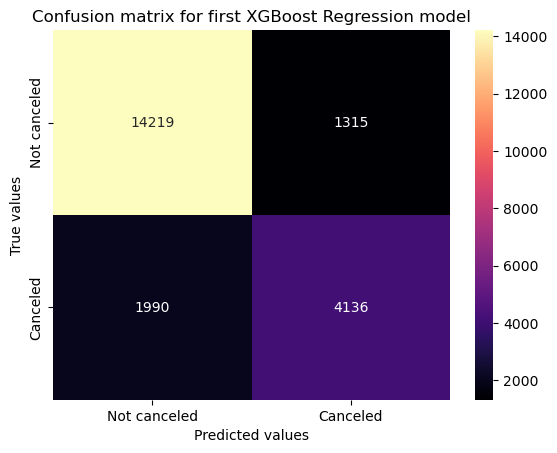

In [59]:
# split data into train and test
X = df.copy()
y = X.pop("is_canceled")
X_train, X_test, y_train, y_test = train_test_split(X, y)

# create model
xgbr_first = xgb.XGBRegressor(n_estimators=400, max_depth=4, learning_rate=0.3, tree_method="approx", gamma=0.1, subsample=0.75)

# cross validate training data and compute scores on this
cv = StratifiedKFold(n_splits=8)
scores = cross_validate(xgbr_first, X_train, y_train, cv=cv, scoring=["explained_variance", "neg_mean_squared_error"])
# work out mean of scores
for key, val in scores.items():
    scores[key] = val.mean()

# fit the model, convert results into predictions (canceled or not canceled) and calculate confusion matrix
xgbr_first.fit(X_train, y_train)
y_pred = xgbr_first.predict(X_test)
y_pred_classes = [1 if y >= 0.5 else 0 for y in y_pred]

cm = confusion_matrix(y_test, y_pred_classes)
scores["sensitivity"] = cm[0, 0] / (cm[0, 0] + cm[0, 1])
scores["specificity"] = cm[1, 1] / (cm[1, 0] + cm[1, 1])
scores["accuracy"] = (cm[0, 0] + cm[1, 1]) / cm.sum()
print("Scores: ", scores)

# plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, cmap="magma", fmt="g")
plt.title("Confusion matrix for first XGBoost Regression model")
plt.xticks(ticks=[0.5, 1.5], labels=["Not canceled", "Canceled"])
plt.yticks(ticks=[0.5, 1.5], labels=["Not canceled", "Canceled"])
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()



In [60]:
# method
# fix learning rate and choose default values for other parameters
# grid search for best num trees
# then select best num trees and refine tree parameters
# then refine gamma and alpha
# reduce learning rate and repeat

Scores:  {'fit_time': 5.65986829996109, 'score_time': 0.04700002074241638, 'test_explained_variance': 0.46463656088701955, 'test_neg_mean_squared_error': -0.10670681087518524, 'sensitivity': 0.9187588515514356, 'specificity': 0.6772771792360431, 'accuracy': 0.8504616805170822}


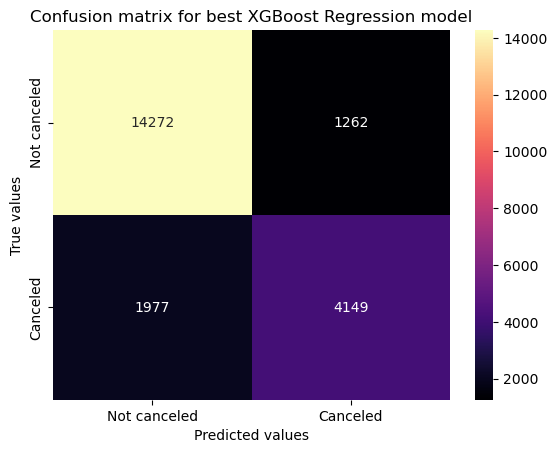

In [61]:
# we now systematically work through hyperparamter choices to get the most effective model
# in terms of mse

params = {"n_estimators" : [400], "tree_method" : ["approx"],
          "learning_rate" : [0.2], "colsample_bytree" : [0.6],
          "subsample" : [1], "gamma" : [0.01], "max_depth" : [6], "alpha" : [0.1]}

# perform grid search and create best estimator
xgbr = xgb.XGBRegressor()
grid = GridSearchCV(xgbr, params, scoring="neg_mean_squared_error")
grid.fit(X_train, y_train)
xgbr = grid.best_estimator_

# cross validate training data and compute scores on this
cv = StratifiedKFold(n_splits=8)
scores = cross_validate(xgbr, X_train, y_train, cv=cv, scoring=["explained_variance", "neg_mean_squared_error"])
# work out mean of scores
for key, val in scores.items():
    scores[key] = val.mean()

# make predictions and calculate confusion matrix
y_pred = xgbr.predict(X_test)
y_pred_classes = [1 if y >= 0.5 else 0 for y in y_pred]

cm = confusion_matrix(y_test, y_pred_classes)
scores["sensitivity"] = cm[0, 0] / (cm[0, 0] + cm[0, 1])
scores["specificity"] = cm[1, 1] / (cm[1, 0] + cm[1, 1])
scores["accuracy"] = (cm[0, 0] + cm[1, 1]) / cm.sum()
print("Scores: ",scores)

# plot confusion matrix

plt.figure()
sns.heatmap(cm, annot=True, cmap="magma", fmt="g")
plt.title("Confusion matrix for best XGBoost Regression model")
plt.xticks(ticks=[0.5, 1.5], labels=["Not canceled", "Canceled"])
plt.yticks(ticks=[0.5, 1.5], labels=["Not canceled", "Canceled"])
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

In [62]:
# print the feature importances
importances = sorted(zip(xgbr.feature_names_in_, xgbr.feature_importances_), key=lambda pair: pair[1], reverse=True)
print("Feature importances:\n")
importances

Feature importances:



[('deposit_type_Non Refund', 0.19119073),
 ('required_car_parking_spaces', 0.055272125),
 ('agent_Other', 0.046467997),
 ('agent_9', 0.04383551),
 ('agent_240', 0.0430403),
 ('total_of_special_requests', 0.042165067),
 ('market_segment_Online TA', 0.04074969),
 ('previous_cancellations', 0.039981123),
 ('deposit_type_No Deposit', 0.032243367),
 ('country_PRT', 0.026808526),
 ('booked_through_agent', 0.02539463),
 ('distribution_channel_TA/TO', 0.025295965),
 ('customer_type_Transient', 0.021273714),
 ('customer_type_Transient-Party', 0.019882495),
 ('requested_car_parking', 0.01919506),
 ('customer_type_Contract', 0.01909043),
 ('arrival_date_year', 0.016711624),
 ('previous_bookings_not_canceled', 0.014469898),
 ('lead_time', 0.013698284),
 ('country_DEU', 0.013314819),
 ('country_GBR', 0.013167454),
 ('market_segment_Direct', 0.013070634),
 ('booking_changes', 0.011144365),
 ('reserved_room_type_A', 0.010428934),
 ('distribution_channel_Other', 0.009900117),
 ('country_FRA', 0.008697

In [63]:
# run 1: n_estimators=200, learning_rate=0.3, colsamplebytree=0.8, subsample=1, maxdepth=5, gamma=0, alpha=0
# run 2: n_estimators=400, learning_rate=0.2, colsamplebytree=0.6, subsample=1, maxdepth=6, gamma=0.01, alpha=0.1
# run 3: set learning rate to 0.1, didnt lead to any significant improvements after playing around

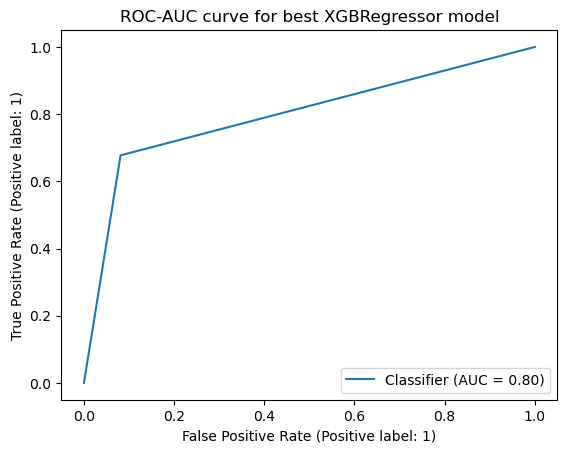

In [64]:
RocCurveDisplay.from_predictions(y_test, y_pred_classes)
plt.title("ROC-AUC curve for best XGBRegressor model")
plt.show()

In [65]:
# when evaluating these models I mainly focused on the metrics: mse, specificity, sensitivity, explained_variance
# through hyper parameter changes i managed to only get small improvements in the model from my intial guess of hyperparameters
# but some of these small improvements in mse where at the cost of reduction in specificity for example
# but overall model is doing good, and AUC of 0.8 is pretty good
# since cancelations definately do have a fair amount of randomness involved in them

# future steps could be to go back to the data and change some things up about it, maybe the data is too sparse, or i should log normalize some of it etc

## Testing Models Part 2 ANN

In [66]:
# going to use keras to make a simple feed forward neural net
# data will need standardising first since this is a gradient based algorithm

In [67]:
# we now standardize data that isnt one hot encoded
cols_to_transform = ['lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
        'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'distance_from_christmas', 'distance_from_easter',
       'distance_from_nearest_holiday']

df[cols_to_transform] = (df[cols_to_transform] - df[cols_to_transform].mean()) / df[cols_to_transform].std()

In [68]:
# creating the neural network model
input_length = X_train.shape[1]

model = Sequential()
model.add(Input(shape=(input_length,)))
model.add(Dense(100, activation="relu", kernel_initializer="random_normal", bias_initializer="zeros"))

model.add(Dense(100, activation="relu", kernel_initializer="random_normal", bias_initializer="zeros"))

model.add(Dense(1, kernel_initializer="random_normal", bias_initializer="zeros"))
          
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=32,epochs=60)


# ended up varying the hyperparameters to try and find the best model, couldnt seem to break 0.11 mse
# definately need to brush up on my understanding of ANNs

Epoch 1/60
2031/2031 [==============================] - 6s 2ms/step - loss: 0.3819 - accuracy: 0.6943 - val_loss: 0.1632 - val_accuracy: 0.7441
Epoch 2/60
2031/2031 [==============================] - 6s 3ms/step - loss: 0.1903 - accuracy: 0.7353 - val_loss: 0.1481 - val_accuracy: 0.7825
Epoch 3/60
2031/2031 [==============================] - 8s 4ms/step - loss: 0.1677 - accuracy: 0.7612 - val_loss: 0.1446 - val_accuracy: 0.7870
Epoch 4/60
2031/2031 [==============================] - 6s 3ms/step - loss: 0.1556 - accuracy: 0.7765 - val_loss: 0.1453 - val_accuracy: 0.7948
Epoch 5/60
2031/2031 [==============================] - 5s 2ms/step - loss: 0.1469 - accuracy: 0.7876 - val_loss: 0.1383 - val_accuracy: 0.8017
Epoch 6/60
2031/2031 [==============================] - 4s 2ms/step - loss: 0.1414 - accuracy: 0.7925 - val_loss: 0.1337 - val_accuracy: 0.8084
Epoch 7/60
2031/2031 [==============================] - 5s 3ms/step - loss: 0.1386 - accuracy: 0.7961 - val_loss: 0.1371 - val_accuracy:

677/677 [==============================] - 1s 1ms/step - loss: 0.1195 - accuracy: 0.8260
{'mse': 0.11950923502445221, 'accuracy': 0.8260387778282166, 'sensitivity': 0.8606926741341573, 'specificity': 0.7381651975187724}


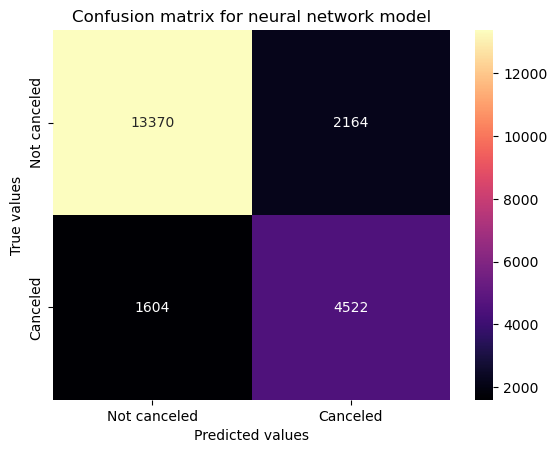

In [69]:
# predict results using the model
y_pred = model.predict(X_test)
y_pred_classes = [1 if y >= 0.5 else 0 for y in y_pred]

# work out scores for model
scores = model.evaluate(X_test, y_test)
scores_dict = {"mse" : scores[0], "accuracy" : scores[1]}

# create confusion matrix from predictions
cm = confusion_matrix(y_test, y_pred_classes)
scores_dict["sensitivity"] = cm[0, 0] / (cm[0, 0] + cm[0, 1])
scores_dict["specificity"] = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(scores_dict)

# plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, cmap="magma", fmt="g")
plt.title("Confusion matrix for neural network model")
plt.xticks(ticks=[0.5, 1.5], labels=["Not canceled", "Canceled"])
plt.yticks(ticks=[0.5, 1.5], labels=["Not canceled", "Canceled"])
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

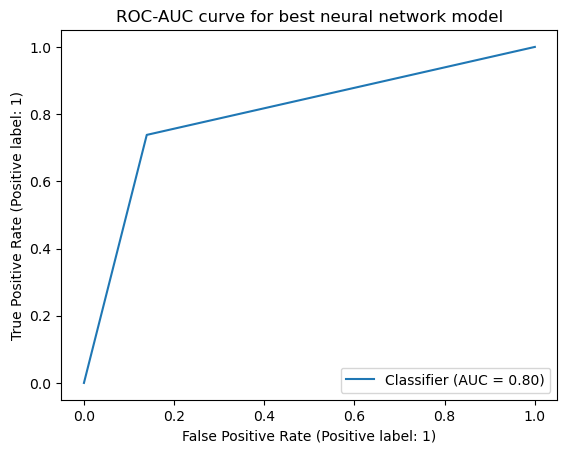

In [70]:
RocCurveDisplay.from_predictions(y_test, y_pred_classes)
plt.title("ROC-AUC curve for best neural network model")
plt.show()

In [71]:
# overall a good result for the neural network model
# worse mse and sensitivity than xgbr model but improved specificity, AUC stayed the same
# hard to tell which model is better, it really depends what the business would be using this information for
# but overall the xgbr performs slighty better so I choose that as the best model

# if i was to expand on this, i would redesign the xgboost model as a classfier and then when doing the grid search
# i would aim to optimise specificity, since it is better to put more weight on predicting bookings as canceled